<a href="https://colab.research.google.com/github/garkul/Transcriptomics.msu/blob/master/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Домашнее задание 4</h1>
<h3> Гаркуль Лидия 4 курс ФББ</h3>

<b>Задание:</b>
Проведите аналогичный анализ с помощью DESeq2 и сравните его результаты с результатами edgeR и реализованной нами GLM (можете построить scatter plot для p-value, полученных разными методами).

В чем основные различия используемых моделей и тестов?


## Установка пакетов и импорт данных:

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libharfbuzz-dev is already the newest version (1.7.2-1ubuntu1).
libharfbuzz-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libgmp-dev libgmpxx4ldbl libpixman-1-dev
  libudunits2-0 libudunits2-data libxcb-shm0-dev
Suggested packages:
  libcairo2-doc gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libfribidi-dev libgmp-dev
  libgmp3-dev libgmpxx4ldbl libpixman-1-dev libudunits2-0 libudunits2-data
  libudunits2-dev libxcb-shm0-dev
0 upgraded, 11 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,735 kB of archives.
After this operation, 6,864 kB of additional disk space will be used.
Get:1 http://archive.ubun

In [ ]:
!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'

In [ ]:
%%R

suppressPackageStartupMessages({
  library(edgeR)
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(tximport)
  library(EnsDb.Mmusculus.v79)
  library(ggplot2)
  library(MASS)
})

In [ ]:
!wget -r -np -R "index.html*" http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/

In [ ]:
!mkdir data
!mkdir data/samples
!mv arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/* data/samples

Импорт данных из salmon с помощью tximport

In [ ]:
%%R

txdb <- EnsDb.Mmusculus.v79
tx2gene <- transcripts(txdb,return.type="DataFrame")
tx2gene <- tx2gene[c("tx_id","gene_id")]

samples <- str_c(c(str_c("wt_water_",c(1,2,3,4)),
                   str_c("wt_bicarb_",c(1,2,3,4)),
                   str_c("ko_water_",c(1,2,3,4)),
                   str_c("ko_bicarb_",c(1,2,3,4))),".sf")
files <- str_c("data/samples/",samples)

In [ ]:
%%R

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T)
#tpm <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T, countsFromAbundance = "lengthScaledTPM")$counts

#Предобработка данных с помощью для дальнейшей работы с DESeq2

In [ ]:
%%R
library(DESeq2)
sampleTable <- data.frame(condition = factor(rep(c("wt_water_", "wt_bicarb_", "ko_water_", "ko_bicarb_"), each = 4)), knock = factor(rep(c("wt","ko"), each =8)), treat = factor(c(rep("water",4),rep("bicarb",4),rep("water",4),rep("bicarb",4))))
rownames(sampleTable) <- colnames(txi$counts)

In [ ]:
%%R
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition)
dds

class: DESeqDataSet 
dim: 39210 16 
metadata(1): version
assays(2): counts avgTxLength
rownames(39210): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00000104526 ENSMUSG00000104527
rowData names(0):
colnames: NULL
colData names(3): condition knock treat


dds содержит информацию о 39210 генах. Отбросим все не белок кодирующие:

In [ ]:
!wget -O data/mouse_mart.csv http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv

--2022-11-22 16:39:01--  http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv
Resolving arcuda.skoltech.ru (arcuda.skoltech.ru)... 195.133.216.197
Connecting to arcuda.skoltech.ru (arcuda.skoltech.ru)|195.133.216.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13518751 (13M)
Saving to: ‘data/mouse_mart.csv’

data/mouse_mart.csv 100%[===================>]  12.89M  8.61MB/s    in 1.5s    

2022-11-22 16:39:03 (8.61 MB/s) - ‘data/mouse_mart.csv’ saved [13518751/13518751]



In [ ]:
%%R
mart <- read.csv("data/mouse_mart.csv")
genetype <- mart$Gene.type[match(rownames(txi$counts),mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE
dds <- dds[typefilter,]

In [ ]:
%%R
dds

class: DESeqDataSet 
dim: 21153 16 
metadata(1): version
assays(2): counts avgTxLength
rownames(21153): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00000104423 ENSMUSG00000104445
rowData names(0):
colnames: NULL
colData names(3): condition knock treat


Белок кодирующих генов всего 21153.

In [ ]:
%%R
keep1 <- rowSums(counts(dds)) >=40
dds_10 <- dds[keep1,]
dds_10

class: DESeqDataSet 
dim: 14622 16 
metadata(1): version
assays(6): counts avgTxLength ... H cooks
rownames(14622): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00000104346 ENSMUSG00000104445
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames: NULL
colData names(3): condition knock treat


In [ ]:
%%R
head(counts(dds))

                   [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
ENSMUSG00000000001  745  894  912  941 1042  774  677  947  644   693   584
ENSMUSG00000000003    0    0    0    0    0    0    0    0    0     0     0
ENSMUSG00000000028   18   16   23   15   13   17   18   20   23    15    14
ENSMUSG00000000037    4   10    4    2    3    0    2    3    5     7     2
ENSMUSG00000000049    0    0    1    0    1    2    0    1    2     2     2
ENSMUSG00000000056  522  631  688  762  609  567  637  711  839   706   594
                   [,12] [,13] [,14] [,15] [,16]
ENSMUSG00000000001   660   789   735   799   765
ENSMUSG00000000003     0     0     0     0     0
ENSMUSG00000000028    21    19    18    21    17
ENSMUSG00000000037     5     0     3     0     2
ENSMUSG00000000049     2     3     0     1     1
ENSMUSG00000000056   882   796   821   754   696


**При фильтрации каунты >=10 остается 15942 гена. По какой-то причине edgeR при такой же фильтрации оставляет в анализе около 13 тысяч генов. Поэтому pvalue сравнивались на данных без фильтрации на количество каунтов.**

## Запуск DESeq2

In [ ]:
%%R
dds <- DESeq(dds)
res <- results(dds)
res

log2 fold change (MLE): condition wt water  vs ko bicarb  
Wald test p-value: condition wt water  vs ko bicarb  
DataFrame with 21153 rows and 6 columns
                     baseMean log2FoldChange     lfcSE       stat      pvalue
                    <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSMUSG00000000001  786.28271       0.448049 0.0704631   6.358628 2.03563e-10
ENSMUSG00000000003    0.00000             NA        NA         NA          NA
ENSMUSG00000000028   18.19808       0.209794 0.3414668   0.614391 5.38957e-01
ENSMUSG00000000037    4.72771       3.750823 1.1233753   3.338887 8.41147e-04
ENSMUSG00000000049    1.16603      -1.748655 1.5114919  -1.156907 2.47311e-01
...                       ...            ...       ...        ...         ...
ENSMUSG00000104301   0.000000             NA        NA         NA          NA
ENSMUSG00000104318   0.181735       0.267639  4.327943  0.0618398    0.950690
ENSMUSG00000104346  24.403592      -0.155162  0.326562 -0.4751369  

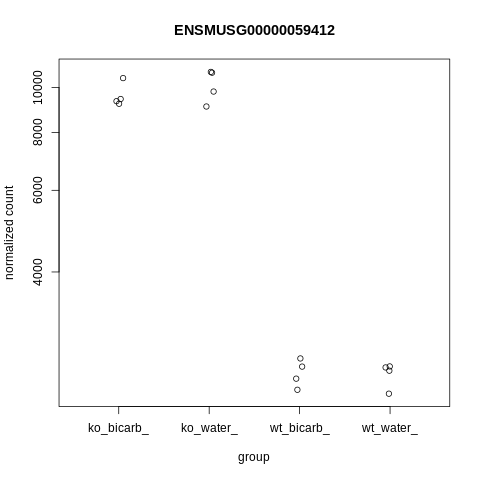

In [ ]:
%%R
plotCounts(dds, gene=which.min(res$padj), intgroup="condition")

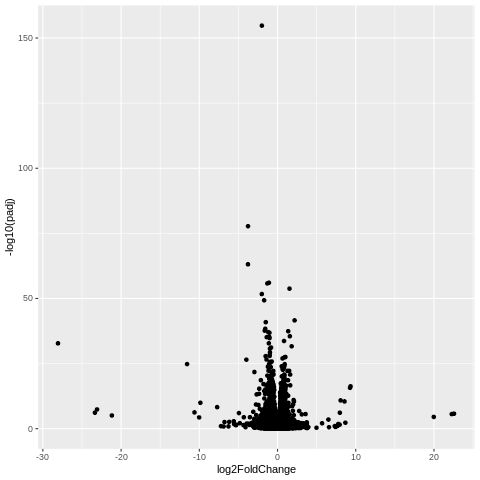

In [ ]:
%%R

res1=as.data.frame(res)
ggplot(res1,aes(x=log2FoldChange,y=-log10(padj)))+
  geom_point()

In [ ]:
%%R
#Сравнение ko_water_ vs ko_bicarb_ 
kotreat_res = results(dds, contrast = c("condition", "ko_water_", "ko_bicarb_"))
head(kotreat_res)

log2 fold change (MLE): condition ko_water_ vs ko_bicarb_ 
Wald test p-value: condition ko water  vs ko bicarb  
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat    pvalue
                   <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001 786.28271      0.0344368 0.0719422  0.478673 0.6321716
ENSMUSG00000000003   0.00000             NA        NA        NA        NA
ENSMUSG00000000028  18.19808      0.1930985 0.3412033  0.565934 0.5714389
ENSMUSG00000000037   4.72771      2.5008839 1.1191478  2.234632 0.0254415
ENSMUSG00000000049   1.16603      0.9902842 1.2264177  0.807461 0.4194011
ENSMUSG00000000056 706.89922      0.3014175 0.1201286  2.509123 0.0121031
                        padj
                   <numeric>
ENSMUSG00000000001  0.984773
ENSMUSG00000000003        NA
ENSMUSG00000000028  0.975700
ENSMUSG00000000037  0.483177
ENSMUSG00000000049        NA
ENSMUSG00000000056  0.353792


In [ ]:
%%R
#Сравнение wt_water_ vs wt_bicarb_ 
wttreat_res = results(dds, contrast = c("condition", "wt_water_", "wt_bicarb_"))
head(wttreat_res)

log2 fold change (MLE): condition wt_water_ vs wt_bicarb_ 
Wald test p-value: condition wt_water_ vs wt_bicarb_ 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat    pvalue
                   <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001 786.28271      0.0831327 0.0700339  1.187035 0.2352138
ENSMUSG00000000003   0.00000             NA        NA        NA        NA
ENSMUSG00000000028  18.19808      0.1155282 0.3452572  0.334615 0.7379156
ENSMUSG00000000037   4.72771      2.5316868 1.0338638  2.448762 0.0143348
ENSMUSG00000000049   1.16603     -1.8954737 1.5379335 -1.232481 0.2177695
ENSMUSG00000000056 706.89922      0.0789372 0.1211986  0.651305 0.5148498
                        padj
                   <numeric>
ENSMUSG00000000001  0.659575
ENSMUSG00000000003        NA
ENSMUSG00000000028        NA
ENSMUSG00000000037        NA
ENSMUSG00000000049        NA
ENSMUSG00000000056  0.848406


In [ ]:
%%R
#Сравнение ko_water_ vs wt_water_ 
kowtwater_res = results(dds, contrast = c("condition", "ko_water_", "wt_water_"))
head(kowtwater_res)

log2 fold change (MLE): condition ko_water_ vs wt_water_ 
Wald test p-value: condition ko_water_ vs wt_water_ 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE       stat      pvalue
                   <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSMUSG00000000001 786.28271     -0.4136119 0.0713997 -5.7929099 6.91772e-09
ENSMUSG00000000003   0.00000             NA        NA         NA          NA
ENSMUSG00000000028  18.19808     -0.0166956 0.3430058 -0.0486744 9.61179e-01
ENSMUSG00000000037   4.72771     -1.2499395 0.9542940 -1.3098055 1.90262e-01
ENSMUSG00000000049   1.16603      2.7389391 1.4587468  1.8775974 6.04363e-02
ENSMUSG00000000056 706.89922      0.5327468 0.1206500  4.4156397 1.00712e-05
                          padj
                     <numeric>
ENSMUSG00000000001 2.02901e-07
ENSMUSG00000000003          NA
ENSMUSG00000000028 9.83773e-01
ENSMUSG00000000037 3.97506e-01
ENSMUSG00000000049          NA
ENSMUSG00000000056 1

In [ ]:
%%R
#Сравнение ko_bicarb_ vs wt_bicarb_ 
kowtbicarb_res = results(dds, contrast = c("condition", "ko_bicarb_", "wt_bicarb_"))
head(kowtbicarb_res)

log2 fold change (MLE): condition ko_bicarb_ vs wt_bicarb_ 
Wald test p-value: condition ko_bicarb_ vs wt_bicarb_ 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 786.28271     -0.3649160  0.070587 -5.169736 2.34425e-07
ENSMUSG00000000003   0.00000             NA        NA        NA          NA
ENSMUSG00000000028  18.19808     -0.0942659  0.343466 -0.274454 7.83735e-01
ENSMUSG00000000037   4.72771     -1.2191366  1.187724 -1.026448 3.04681e-01
ENSMUSG00000000049   1.16603     -0.1468187  1.319620 -0.111258 9.11411e-01
ENSMUSG00000000056 706.89922      0.3102665  0.120680  2.570995 1.01407e-02
                          padj
                     <numeric>
ENSMUSG00000000001 5.69717e-06
ENSMUSG00000000003          NA
ENSMUSG00000000028 8.87565e-01
ENSMUSG00000000037          NA
ENSMUSG00000000049          NA
ENSMUSG00000000056 4.732

In [ ]:
%%R
DESeq2_KOtreat = as.data.frame(kotreat_res)
DESeq2_WTtreat = as.data.frame(wttreat_res)
DESeq2_WaterKOWT = as.data.frame(kowtwater_res)
DESeq2_BicarbKOWT = as.data.frame(kowtbicarb_res)

## Анализ экспрессии с помощью edgeR на тех же данных с семинара

Повторим шаги семинара, чтобы сравнить pvalue с DESeq2

In [ ]:
%%R
cts <- txi$counts
normMat <- txi$length

# Obtaining per-observation scaling factors for length, adjusted to avoid
# changing the magnitude of the counts.
normMat <- normMat/exp(rowMeans(log(normMat)))
normCts <- cts/normMat

# Computing effective library sizes from scaled counts, to account for
# composition biases between samples.
eff.lib <- calcNormFactors(normCts) * colSums(normCts)

# Combining effective library sizes with the length factors, and calculating
# offsets for a log-link GLM.
normMat <- sweep(normMat, 2, eff.lib, "*")
normMat <- log(normMat)

genelen <- txi$length

In [ ]:
%%R

genetype <- mart$Gene.type[match(rownames(cts),mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE
cts <- cts[typefilter,]
normMat <- normMat[typefilter,]
genelen <- genelen[typefilter,]

In [ ]:
%%R
str(cts)

 num [1:21153, 1:16] 745 0 18 4 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:21153] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000037" ...
  ..$ : NULL


In [ ]:
%%R

y <- DGEList(cts)
y <- scaleOffset(y, normMat)

knock <- c(rep("wt",8),rep("ko",8))
treat <- c(rep("water",4),rep("bicarb",4),rep("water",4),rep("bicarb",4))
group <- factor(str_c(knock,treat,sep="_"))
design <- model.matrix(~0+group)
colnames(design) <- levels(group)

In [ ]:
%%R

require(org.Mm.eg.db)
Symbol <- mapIds(org.Mm.eg.db, keys=rownames(y), keytype="ENSEMBL", column="SYMBOL")
Entrez <- mapIds(org.Mm.eg.db, keys=rownames(y), keytype="ENSEMBL", column="ENTREZID")
y$genes <- data.frame(Symbol=Symbol, Entrez=Entrez)
y$genes["length"] <- rowMeans(genelen)

In [ ]:
%%R

keep <- filterByExpr(y,design=design, min.total.count=10,min.count=10)
y_10 <- y[keep, , keep.lib.sizes=FALSE]

y <- estimateDisp(y, design, robust=TRUE)
str(y_10)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 13
  .. ..$ : num [1:13459, 1:16] 745 18 522 331 577 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:13459] "ENSMUSG00000000001" "ENSMUSG00000000028" "ENSMUSG00000000056" "ENSMUSG00000000058" ...
  .. .. .. ..$ : chr [1:16] "Sample1" "Sample2" "Sample3" "Sample4" ...
  .. ..$ :'data.frame':	16 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 1 level "1": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ lib.size    : num [1:16] 9490363 10294170 11459136 10827879 11737575 ...
  .. .. ..$ norm.factors: num [1:16] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ : num [1:13459, 1:16] 16.2 16 16.3 16.3 16.2 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:13459] "ENSMUSG00000000001" "ENSMUSG00000000028" "ENSMUSG00000000056" "ENSMUSG00000000058" ...
  .. .. .. ..$ : NULL
  .. ..$ :'data.frame':	13459 obs. of  3 variables:
  .. .. ..$ Symbol: chr [1:13459] "Gnai3" "Cdc45" "Narf" "Cav2" ...
  .. .. 

In [ ]:
%%R
head(keep)

ENSMUSG00000000001 ENSMUSG00000000003 ENSMUSG00000000028 ENSMUSG00000000037 
              TRUE              FALSE               TRUE              FALSE 
ENSMUSG00000000049 ENSMUSG00000000056 
             FALSE               TRUE 


In [ ]:
%%R

fit <- glmQLFit(y, design, robust=TRUE)

my.contrasts <- makeContrasts(
  KO.BicarbvsWater = ko_bicarb-ko_water,
  WT.BicarbvsWater = wt_bicarb-wt_water,
  Bicarb.KOvsWT = ko_bicarb-wt_bicarb,
  Water.KOvsWT = ko_water-wt_water,
  KOWT.treat = (ko_bicarb-ko_water)-(wt_bicarb-wt_water),
  levels=design)

qlf_WaterKOWT <- glmQLFTest(fit, contrast=my.contrasts[,"Water.KOvsWT"])
qlf_BicarbKOWT <- glmQLFTest(fit, contrast=my.contrasts[,"Bicarb.KOvsWT"])
qlf_KOtreat <- glmQLFTest(fit, contrast=my.contrasts[,"KO.BicarbvsWater"])
qlf_WTtreat <- glmQLFTest(fit, contrast=my.contrasts[,"WT.BicarbvsWater"])
qlf_KOWTtreat <- glmQLFTest(fit, contrast=my.contrasts[,"KOWT.treat"])

In [ ]:
%%R

edgeR_WaterKOWT <- topTags(qlf_WaterKOWT,n=nrow(y))$table
edgeR_BicarbKOWT <- topTags(qlf_BicarbKOWT,n=nrow(y))$table
edgeR_KOtreat <- topTags(qlf_KOtreat,n=nrow(y))$table
edgeR_WTtreat <- topTags(qlf_WTtreat,n=nrow(y))$table

In [ ]:
%%R
head(edgeR_KOtreat)

                    Symbol Entrez    length      logFC   logCPM        F
ENSMUSG00000013646 Sh3bp5l  79566 2663.6188  1.3387912 4.316745 87.18071
ENSMUSG00000018459 Slc13a3 114644 3582.5841 -0.6701305 9.643126 62.64368
ENSMUSG00000005233   Spc25  66442  590.1003 -0.7765876 4.822291 42.62467
ENSMUSG00000038173   Enpp6 320981 3396.6087 -0.5380002 6.678032 35.41977
ENSMUSG00000024650 Slc22a6  18399 3531.9903 -0.5257144 8.661980 31.13790
ENSMUSG00000093930  Hmgcs1 208715 2123.2800 -0.5132723 7.542438 29.23505
                         PValue         FDR
ENSMUSG00000013646 5.835153e-08 0.001234310
ENSMUSG00000018459 5.475232e-07 0.005790879
ENSMUSG00000005233 6.224092e-06 0.043886075
ENSMUSG00000038173 1.850012e-05 0.097833249
ENSMUSG00000024650 3.817004e-05 0.161482178
ENSMUSG00000093930 5.383711e-05 0.189802745


## Сравнение двух методов

In [ ]:
%%R
edgeR_KOtreat["ENSMUSG00000000001",]

                   Symbol Entrez   length       logFC   logCPM          F
ENSMUSG00000000001  Gnai3  14679 1542.151 -0.01863023 6.062229 0.06503114
                      PValue FDR
ENSMUSG00000000001 0.8018914   1


In [ ]:
%%R
DESeq2_KOtreat["ENSMUSG00000000001",]

                   baseMean log2FoldChange      lfcSE      stat    pvalue
ENSMUSG00000000001 786.2827     0.03443677 0.07194223 0.4786726 0.6321716
                        padj
ENSMUSG00000000001 0.9847729


In [ ]:
%%R
write.csv(as.data.frame(DESeq2_KOtreat), 
          file="results_DEeq_KOtreat.csv")
write.csv(as.data.frame(edgeR_KOtreat), 
          file="results_edgeR_KOtreat.csv")

write.csv(as.data.frame(DESeq2_WTtreat), 
          file="results_DEeq_WTtreat.csv")
write.csv(as.data.frame(edgeR_WTtreat), 
          file="results_edgeR_WTtreat.csv")

write.csv(as.data.frame(DESeq2_WaterKOWT), 
          file="results_DEeq_WaterKOWT.csv")
write.csv(as.data.frame(edgeR_WaterKOWT), 
          file="results_edgeR_WaterKOWT.csv")

write.csv(as.data.frame(DESeq2_BicarbKOWT), 
          file="results_DEeq_BicarbKOWT.csv")
write.csv(as.data.frame(edgeR_BicarbKOWT), 
          file="results_edgeR_BicarbKOWT.csv")

In [ ]:
%%R
d_KOtreat <- read.csv("results_DEeq_KOtreat.csv")
e_KOtreat <- read.csv("results_edgeR_KOtreat.csv")
d_KOtreat <- d_KOtreat[order(d_KOtreat$X),]
e_KOtreat <- e_KOtreat[order(e_KOtreat$X),]

d_WTtreat <- read.csv("results_DEeq_WTtreat.csv")
e_WTtreat <- read.csv("results_edgeR_WTtreat.csv")
d_WTtreat <- d_WTtreat[order(d_WTtreat$X),]
e_WTtreat <- e_WTtreat[order(e_WTtreat$X),]

d_WaterKOWT <- read.csv("results_DEeq_WaterKOWT.csv")
e_WaterKOWT <- read.csv("results_edgeR_WaterKOWT.csv")
d_WaterKOWT <- d_WaterKOWT[order(d_WaterKOWT$X),]
e_WaterKOWT <-e_WaterKOWT[order(e_WaterKOWT$X),]

d_BicarbKOWT <- read.csv("results_DEeq_BicarbKOWT.csv")
e_BicarbKOWT <- read.csv("results_edgeR_BicarbKOWT.csv")
d_BicarbKOWT <-d_BicarbKOWT[order(d_BicarbKOWT$X),]
e_BicarbKOWT <- e_BicarbKOWT[order(e_BicarbKOWT$X),]

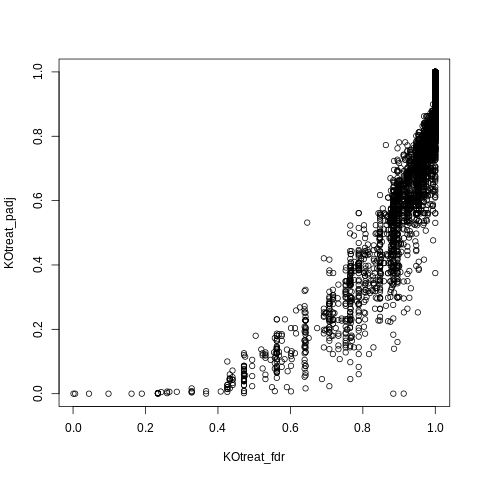

In [ ]:
%%R
KOtreat_fdr <- e_KOtreat$FDR
KOtreat_padj <- d_KOtreat$padj

plot(KOtreat_fdr, KOtreat_padj)

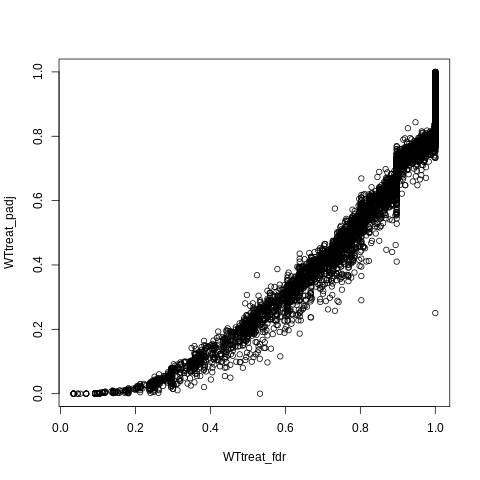

In [ ]:
%%R
WTtreat_fdr <- e_WTtreat$FDR
WTtreat_padj <- d_WTtreat$padj

plot(WTtreat_fdr, WTtreat_padj)

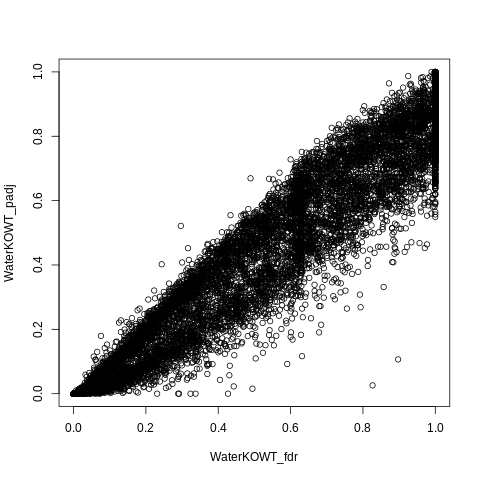

In [ ]:
%%R
WaterKOWT_fdr <- e_WaterKOWT$FDR
WaterKOWT_padj <- d_WaterKOWT$padj

plot(WaterKOWT_fdr, WaterKOWT_padj)

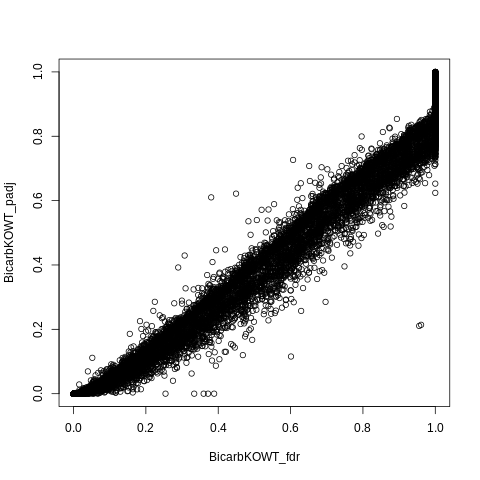

In [ ]:
%%R
BicarbKOWT_fdr <- e_BicarbKOWT$FDR
BicarbKOWT_padj <- d_BicarbKOWT$padj

plot(BicarbKOWT_fdr, BicarbKOWT_padj)